In [1]:
# util for SFG DRO
import torch
from sklearn.kernel_approximation import RBFSampler
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from torch.optim.swa_utils import AveragedModel  # average model weights
import torch.optim as optim



class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# This function builds the model for one-vs-all classification
def buildModel(task=None, method=None,n_hidden=100, device=None, loss_reduction='mean'):
    n_output = 1  # Only one output node for one-vs-all classification
    loss_erm = nn.BCEWithLogitsLoss(reduction=loss_reduction)  # Binary Cross-Entropy Loss
    
    # Defining the model architecture
    modelDecision = nn.Sequential(
        Flatten(), 
        nn.Linear(784, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_output)
    ).to(device)
    
    return modelDecision, loss_erm

def computeErr(yp, y,task=None,shuffle_test=False):
    predictions = (yp > 0).float()  # Converting model outputs to binary predictions
    err = (predictions != y).float().mean().item()  # Calculating the error rate
    return err





In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def mnistData(task='one_vs_all', class_num=0, batch_size=100, shuffle_test=False):
    if class_num < 0 or class_num > 9:
        raise ValueError("class_num should be between 0 and 9")

    transform = transforms.Compose([transforms.ToTensor()])
    
    mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transform)
    
    if task == 'binary':
        # Ensure labels are floats for binary classification
        train_idx = (mnist_train.targets == 0) | (mnist_train.targets == 1)
        mnist_train.targets = mnist_train.targets[train_idx]
        mnist_train.data = mnist_train.data[train_idx]

        test_idx = (mnist_test.targets == 0) | (mnist_test.targets == 1)
        mnist_test.targets = mnist_test.targets[test_idx]
        mnist_test.data = mnist_test.data[test_idx]

    elif task == 'one_vs_all':
        # Ensure labels are floats for one-vs-all classification
        mnist_train.targets = (mnist_train.targets == class_num).float()
        mnist_test.targets = (mnist_test.targets == class_num).float()

    elif task == 'multi':
        pass  # your multi-class handling code here

    else:
        raise NotImplementedError

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=shuffle_test)

    return train_loader, test_loader




In [3]:
def apply_gd(x, step_gamma=0.1):
    if x.grad is None:
        return x
    xnew = x - step_gamma * x.grad.detach()
    x.grad.data.zero_()
    return xnew


# a general loss function
def loss_general_se(output, target):
    return torch.sum((output - target) ** 2, dim=1).reshape(-1, 1)


def sample_zeta(X, y, zeta_sample_method=None, loss_erm=None, modelDecision=None, n_sample_zeta=1, epsilon_attack=0.0, learn_task=None, F=None):
    Z = None
    yperturb = None

    for _ in range(n_sample_zeta):
        delta = zeta_sample_method(loss_erm, modelDecision, X, y, randomize=True, epsilon=epsilon_attack,
                                   alpha=0.01, num_iter=20, task=learn_task, mklF=F)  # used with the new pgd
        # delta = attack(loss_erm, modelDecision, X, y, randomize=True, epsilon=1.0, alpha=0.01, num_iter=20, task=learn_task, rkhsF=F) # used with the new pgd

        Zperturb = X + delta
        if Z is not None:  # also penalize the original loss at unperturbed data
            Z = torch.cat((Zperturb, Z))  # cat new perturb Z with the old
            yperturb = torch.cat((yperturb, y))
        else:
            Z = Zperturb
            yperturb = y

    return Z, yperturb

In [4]:
def sfg_train_step(X=None, y=None, just_rand=None, loss_erm=None, modelDecision=None, n_sample_zeta=None, epsilon_attack=None,
                   learn_task=None, F=None, epsilon=None, stat_plot=None, i_decay_csa=None, is_step_const=None,
                   model_class=None, modelSWA=None):
    Z, y = sample_zeta(X, y, zeta_sample_method=just_rand, loss_erm=loss_erm,
                       modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                       epsilon_attack=epsilon_attack, learn_task=learn_task, F=F)
    yp = evalutateErmModel(modelDecision, Z,
                           task=learn_task)  # use original model in ERM to run thru data X
    # kdro surrogate loss
    f_emp = torch.mean(F(X, fit=True))  # emp loss under emp loss
    # '''KDRO obj'''
    obj = f_emp + epsilon * F.norm()  # obj of the optimization problem
    #  original loss l eval on z
    loss_emp = loss_erm(yp, y).reshape(-1, 1)
    assert loss_emp.shape == F(Z).shape
    cons_sip = loss_emp - F(Z)  # constraint function of SIP. G(th, zeta)
    partial_moment = 1
    if partial_moment:  # use functional constr: E h(l-f) = 0
        max_cons_g = torch.mean(torch.nn.functional.relu(cons_sip))
    else:
        max_cons_g, id_max = torch.max(cons_sip, 0)  # max of violation across all samples zeta
    # bookeeping
    stat_plot["max_cons_violation"].append(max_cons_g.data.detach())
    stat_plot["obj"].append(obj.data.detach())

    '''CSA - SGD step size'''
    # threshold
    threshold_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    # threshold_csa = 0.01 # constant step
    # step size
    if is_step_const:
        step_csa = 0.01
    else:
        step_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    i_decay_csa += 1
    # %% update dec var: th, f0, f
    # zero gradient before backward
    try:
        for w in modelDecision.parameters(): w.grad.data.zero_()
        for w in F.model.parameters(): w.grad.data.zero_()
    except:
        pass
    if max_cons_g <= threshold_csa:  # if constr satisfied
        obj.backward()
        # there is no th update since obj doens't have th in it

        # %% if cons. satisfied, polyak averaging to keep track of average
        if model_class == 'mlp':
            modelSWA.update_parameters(modelDecision)  # model with averaged weights
            # pass
        else:
            raise NotImplementedError

    else:  # cons violation
        if partial_moment:
            max_cons_g.backward()  # diff this:  E h(l-f)
        else:
            cons_sip[id_max].backward()

        # update model var
        if model_class == 'mlp':
            for weight in modelDecision.parameters():
                weight.data = apply_gd(weight, step_csa)
        else:
            raise NotImplementedError
    # update f0, weights of f
    for weight in F.model.parameters():
        weight.data = apply_gd(weight, step_csa)
    return i_decay_csa, stat_plot


In [5]:
def run_test(test_loader, modelERM, loss_erm, loaded, attack_function=None, attack_range=None, task=None, n_test=100, device=None):
    D = {'err': [], 'attack': [], 'sig': []}
    for attack_strength in attack_range:
        i_test = 0

        err_this_attack = []
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            if task=='binary' or task=='one_vs_all':
                y = y.float()
            i_test += 1
            if i_test > n_test:
                break

            delta = attack_function(loss_erm, modelERM, X, y, attack_strength, task=task)

            # evaluate attack
            #         plt.figure()
            yp = evalutateErmModel(loaded['model'], X + delta, task=task)
            err_kdro = computeErr(yp, y, task=task)

            err_this_attack.append(deepcopy(err_kdro))

        # for each attack, compute average
        D['err'].append(np.mean(err_this_attack))
        D['sig'].append(np.std(err_this_attack))
        D['attack'].append(attack_strength)

    D['n_run'] = len(err_this_attack)  # total number of runs
    D['eps_dro'] = loaded['epsilon']
    D['is_erm'] = loaded['is_erm']
    try:
        D['is_pgd'] = loaded['is_pgd']
    except:
        pass

    D['task'] = task

    return D



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as Fa

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MKLfunction(nn.Module):
    def __init__(self, input_shape, model=None, gamma=None, degree=3, coef0=1, kernel_list=None):
        super(MKLfunction, self).__init__()
        self.model = model
        self.input_shape = input_shape
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        
        self.flatten = Flatten()  # Instantiate the Flatten module
        self.kernel_list = kernel_list or [self.rbf_kernel_torch, self.polynomial_kernel_torch]
        self.kernel_weights = nn.Parameter(torch.ones(len(self.kernel_list)), requires_grad=True)

    def rbf_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        gamma = self.gamma if self.gamma is not None else 1.0 / X.size(1)
        
        sq_norms_X = torch.sum(X**2, dim=1)
        sq_norms_Y = torch.sum(Y**2, dim=1)
        cross_products = torch.mm(X, Y.t())
        distances = sq_norms_X[:, None] + sq_norms_Y[None, :] - 2 * cross_products
        return torch.exp(-gamma * distances)

    def polynomial_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        products = torch.mm(X, Y.t())
        return (products + self.coef0)**self.degree

    def compute_combined_kernel(self, X):
        X_tensor = X.clone().detach().requires_grad_(True)
        kernel_matrices = [k(X_tensor) for k in self.kernel_list]
        normalized_weights = Fa.softmax(self.kernel_weights, dim=0)
        K_combined = sum(w * km for w, km in zip(normalized_weights, kernel_matrices))
        return K_combined

    def forward(self, X, fit=False):
        K_combined = self.compute_combined_kernel(X)
        
        # Ensure that the model is correctly defined for the shape of K_combined
        if self.model is None or self.model[1].in_features != K_combined.shape[1]:
            self.model = nn.Sequential(Flatten(), nn.Linear(K_combined.shape[1], 1, bias=True))

        mklF = self.model(K_combined)
        return mklF

    def norm(self):
        return torch.norm(self.kernel_weights)


In [7]:



def evalutateErmModel(modelDecision, X, task=None):
    yp = modelDecision(X.view(X.shape[0], -1)).squeeze()  # No need for indexing in one-vs-all
    return yp





In [8]:
def pgd_linf(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None):
    """ Construct PGD adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = loss_attack(evalutateErmModel(model, X + delta, task=task), y)
        if loss.numel() != 1:  # This is to check if the tensor is not a scalar
            loss = loss.sum()  # Or use mean(), depending on your specific requirements
        loss.backward()

        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()

    # for w in model.parameters(): w.grad.data.zero_()
        # for w in rkhsF.model.parameters(): w.grad.data.zero_()
    return delta.detach()


def just_rand(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None, **kwargs):
    """ just use random noises to sample new samples"""
    delta = torch.rand_like(X, requires_grad=False)
    delta.data = 2* (delta.data - 0.5) * epsilon

    return delta.detach()

In [9]:
# params
n_epoch_gd = 10# how many epochs of SFG to run
learn_task = 'one_vs_all'
mini_batch = 20 
model_class = 'mlp'
loss_reduction = 'none'
n_rand_feat = 500
n_sample_zeta = 150
epsilon_attack = 0.5  # largest perturbation of the domain allowed in RO
epsilon = 1.0  # Kernel DRO ambiguity size
is_step_const = 0  # use decay step size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up
train_loader, test_loader = mnistData(task=learn_task, batch_size=mini_batch)
modelDecision, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device,
                                     loss_reduction=loss_reduction)
modelSWA = AveragedModel(modelDecision)


X_initial, y_initial = next(iter(train_loader))
X_initial = X_initial.requires_grad_(True).to(device)

# Define the model to be used within MKLfunction
input_features = X_initial.shape[1] * X_initial.shape[2] * X_initial.shape[3]
mkl_model = nn.Sequential(
    Flatten(),
    nn.Linear(input_features, 96),  # Adjust the output features as needed
    nn.ReLU(),
    nn.Linear(96, 1)
).to(device)

# Instantiate the MKLfunction with the newly defined model
F = MKLfunction(X_initial.shape, model=mkl_model)
# Bookkeeping
stat_plot = {"max_cons_violation": [], "obj": []}

In [10]:
from tqdm import tqdm

print("=========Training SFG DRO=========")

i_decay_csa = 0  # counter for threshold decay

# Wrapping the range function with tqdm to get progress bar for epochs
for i_epoch in tqdm(range(n_epoch_gd), desc="Epochs"):
    # Wrapping the train_loader with tqdm to get progress bar for batches
    for X, y in tqdm(train_loader, desc="Batches", leave=False):
        X, y = X.to(device), y.to(device)
        if learn_task=='binary' or learn_task=='one_vs_all':
            y = y.float()

        i_decay_csa, stat_plot = sfg_train_step(X=X, y=y, just_rand=just_rand, loss_erm=loss_erm,
                                                modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                                                epsilon_attack=epsilon_attack,
                                                learn_task=learn_task, F=F, epsilon=epsilon, stat_plot=stat_plot,
                                                i_decay_csa=i_decay_csa,
                                                is_step_const=is_step_const,
                                                model_class=model_class, modelSWA=modelSWA)
    print('epoch:', i_epoch, '/', n_epoch_gd)

print("=========Training Finished=========")

=========Training SFG DRO=========


Batches:   4%|▍         | 126/3000 [04:04<1:31:15,  1.91s/it]


Batches:   8%|▊         | 252/3000 [07:58<1:23:23,  1.82s/it]


Batches:  13%|█▎        | 378/3000 [11:51<1:20:00,  1.83s/it]


Batches:  17%|█▋        | 504/3000 [15:43<1:14:57,  1.80s/it]


Batches:  21%|██        | 630/3000 [19:38<1:13:18,  1.86s/it]


Batches:  25%|██▌       | 756/3000 [23:31<1:10:43,  1.89s/it]


Batches:  29%|██▉       | 882/3000 [27:24<1:04:50,  1.84s/it]


Batches:  34%|███▎      | 1007/3000 [31:13<58:38,  1.77s/it]


Batches:  38%|███▊      | 1133/3000 [35:07<57:52,  1.86s/it]


Batches:  42%|████▏     | 1261/3000 [39:04<54:12,  1.87s/it]


Batches:  46%|████▋     | 1389/3000 [42:59<50:12,  1.87s/it]


Batches:  50%|█████     | 1515/3000 [47:33<56:52,  2.30s/it]


Batches:  55%|█████▍    | 1643/3000 [52:25<51:42,  2.29s/it]


Batches:  59%|█████▉    | 1771/3000 [57:17<46:39,  2.28s/it]


Batches:  63%|██████▎   | 1897/3000 [1:01:59<42:00,  2.28s/it]


Batches:  67%|██████▋   | 2021/3000 [1:06:43<36:57,  2.26s/it]


Batches:  72%|███████▏  | 2145/3000 [1:11:22<32:41,  2.29s/it]


Batches:  76%|███████▌  | 2269/3000 [1:15:39<21:57,  1.80s/it]


Batches:  80%|███████▉  | 2393/3000 [1:19:29<18:14,  1.80s/it]


Batches:  84%|████████▍ | 2517/3000 [1:23:15<14:51,  1.84s/it]


Batches:  88%|████████▊ | 2641/3000 [1:27:01<11:06,  1.86s/it]


Batches:  92%|█████████▏| 2765/3000 [1:30:45<07:17,  1.86s/it]


Batches:  96%|█████████▋| 2889/3000 [1:34:30<03:23,  1.84s/it]


Epochs:  10%|█         | 1/10 [1:37:50<14:40:38, 5870.98s/it] 

epoch: 0 / 10



Batches:   4%|▍         | 126/3000 [03:48<1:26:09,  1.80s/it]


Batches:   8%|▊         | 252/3000 [07:36<1:25:52,  1.87s/it]


Batches:  13%|█▎        | 378/3000 [11:25<1:17:50,  1.78s/it]


Batches:  17%|█▋        | 504/3000 [15:12<1:13:48,  1.77s/it]


Batches:  21%|██        | 630/3000 [19:06<1:11:51,  1.82s/it]


Batches:  25%|██▌       | 756/3000 [22:54<1:07:51,  1.81s/it]


Batches:  29%|██▉       | 882/3000 [26:42<1:04:45,  1.83s/it]


Batches:  34%|███▎      | 1008/3000 [30:32<1:01:33,  1.85s/it]


Batches:  38%|███▊      | 1135/3000 [34:21<55:51,  1.80s/it]


Batches:  42%|████▏     | 1263/3000 [38:12<50:38,  1.75s/it]


Batches:  46%|████▋     | 1391/3000 [42:05<49:06,  1.83s/it]


Batches:  51%|█████     | 1519/3000 [45:55<44:56,  1.82s/it]


Batches:  55%|█████▍    | 1647/3000 [49:46<41:19,  1.83s/it]


Batches:  59%|█████▉    | 1775/3000 [53:36<35:58,  1.76s/it]


Batches:  63%|██████▎   | 1903/3000 [57:27<34:44,  1.90s/it]


Batches:  68%|██████▊   | 2029/3000 [1:01:16<29:59,  1.85s/it]


Batches:  72%|███████▏  | 2153/3000 [1:05:00<25:26,  1.80s/it]


Batches:  76%|███████▌  | 2277/3000 [1:08:44<22:36,  1.88s/it]


Batches:  80%|████████  | 2401/3000 [1:12:28<18:16,  1.83s/it]


Batches:  84%|████████▍ | 2525/3000 [1:16:12<14:24,  1.82s/it]


Batches:  88%|████████▊ | 2649/3000 [1:19:56<10:38,  1.82s/it]


Batches:  92%|█████████▏| 2773/3000 [1:23:39<06:54,  1.83s/it]


Batches:  97%|█████████▋| 2897/3000 [1:27:23<03:09,  1.84s/it]


Epochs:  20%|██        | 2/10 [3:08:19<12:28:06, 5610.83s/it] 

epoch: 1 / 10



Batches:   4%|▍         | 126/3000 [03:47<1:28:45,  1.85s/it]


Batches:   8%|▊         | 252/3000 [07:36<1:27:13,  1.90s/it]


Batches:  13%|█▎        | 378/3000 [11:23<1:18:37,  1.80s/it]


Batches:  17%|█▋        | 504/3000 [15:11<1:13:08,  1.76s/it]


Batches:  21%|██        | 630/3000 [18:59<1:11:52,  1.82s/it]


Batches:  25%|██▌       | 756/3000 [22:48<1:07:02,  1.79s/it]


Batches:  29%|██▉       | 882/3000 [26:35<1:03:33,  1.80s/it]


Batches:  34%|███▎      | 1007/3000 [30:21<1:00:23,  1.82s/it]


Batches:  38%|███▊      | 1134/3000 [34:10<54:38,  1.76s/it]


Batches:  42%|████▏     | 1262/3000 [38:02<51:33,  1.78s/it]


Batches:  46%|████▋     | 1390/3000 [41:52<48:25,  1.80s/it]


Batches:  51%|█████     | 1518/3000 [45:44<45:54,  1.86s/it]


Batches:  55%|█████▍    | 1646/3000 [49:34<40:09,  1.78s/it]


Batches:  59%|█████▉    | 1774/3000 [53:25<39:07,  1.91s/it]


Batches:  63%|██████▎   | 1902/3000 [57:15<33:24,  1.83s/it]


Batches:  68%|██████▊   | 2028/3000 [1:01:05<28:34,  1.76s/it]


Batches:  72%|███████▏  | 2152/3000 [1:04:49<24:40,  1.75s/it]


Batches:  76%|███████▌  | 2276/3000 [1:08:33<22:07,  1.83s/it]


Batches:  80%|████████  | 2400/3000 [1:12:19<18:10,  1.82s/it]


Batches:  84%|████████▍ | 2524/3000 [1:16:05<14:53,  1.88s/it]


Batches:  88%|████████▊ | 2648/3000 [1:19:48<10:35,  1.81s/it]


Batches:  92%|█████████▏| 2772/3000 [1:23:31<06:40,  1.76s/it]


Batches:  97%|█████████▋| 2896/3000 [1:27:14<03:06,  1.79s/it]


Epochs:  30%|███       | 3/10 [4:38:43<10:44:37, 5525.33s/it] 

epoch: 2 / 10



Batches:   4%|▍         | 126/3000 [03:46<1:23:41,  1.75s/it]


Batches:   8%|▊         | 252/3000 [07:35<1:26:14,  1.88s/it]


Batches:  13%|█▎        | 378/3000 [11:22<1:18:40,  1.80s/it]


Batches:  17%|█▋        | 504/3000 [15:09<1:13:12,  1.76s/it]


Batches:  21%|██        | 630/3000 [18:57<1:11:07,  1.80s/it]


Batches:  25%|██▌       | 756/3000 [22:45<1:07:38,  1.81s/it]


Batches:  29%|██▉       | 882/3000 [26:36<1:03:58,  1.81s/it]


Batches:  34%|███▎      | 1008/3000 [30:25<59:25,  1.79s/it]


Batches:  38%|███▊      | 1135/3000 [34:15<57:53,  1.86s/it]


Batches:  42%|████▏     | 1263/3000 [38:08<58:05,  2.01s/it]


Batches:  46%|████▋     | 1391/3000 [42:03<48:50,  1.82s/it]


Batches:  51%|█████     | 1519/3000 [45:55<44:48,  1.82s/it]


Batches:  55%|█████▍    | 1647/3000 [49:47<40:15,  1.79s/it]


Batches:  59%|█████▉    | 1775/3000 [53:42<37:05,  1.82s/it]


Batches:  63%|██████▎   | 1903/3000 [58:20<40:35,  2.22s/it]


Batches:  68%|██████▊   | 2028/3000 [1:03:02<35:53,  2.22s/it]


Batches:  72%|███████▏  | 2152/3000 [1:07:46<31:54,  2.26s/it]


Batches:  76%|███████▌  | 2276/3000 [1:12:33<27:15,  2.26s/it]


Batches:  80%|████████  | 2400/3000 [1:17:15<22:41,  2.27s/it]


Batches:  84%|████████▍ | 2524/3000 [1:21:21<14:09,  1.78s/it]


Batches:  88%|████████▊ | 2648/3000 [1:25:08<10:26,  1.78s/it]


Batches:  92%|█████████▏| 2772/3000 [1:28:55<06:52,  1.81s/it]


Batches:  97%|█████████▋| 2896/3000 [1:32:39<03:12,  1.85s/it]


Epochs:  40%|████      | 4/10 [6:14:31<9:21:20, 5613.43s/it]  

epoch: 3 / 10



Batches:   4%|▍         | 126/3000 [04:11<1:47:23,  2.24s/it]


Batches:   8%|▊         | 252/3000 [08:32<1:24:47,  1.85s/it]


Batches:  13%|█▎        | 378/3000 [12:29<1:20:03,  1.83s/it]


Batches:  17%|█▋        | 504/3000 [16:26<1:17:14,  1.86s/it]


Batches:  21%|██        | 630/3000 [20:23<1:15:27,  1.91s/it]


Batches:  25%|██▌       | 756/3000 [24:18<1:08:20,  1.83s/it]


Batches:  29%|██▉       | 882/3000 [28:21<1:20:05,  2.27s/it]


Batches:  34%|███▎      | 1007/3000 [33:03<1:13:35,  2.22s/it]


Batches:  38%|███▊      | 1131/3000 [37:16<59:00,  1.89s/it]


Batches:  42%|████▏     | 1257/3000 [41:26<1:08:24,  2.35s/it]


Batches:  46%|████▌     | 1381/3000 [46:06<1:01:04,  2.26s/it]


Batches:  50%|█████     | 1507/3000 [50:53<55:32,  2.23s/it]


Batches:  54%|█████▍    | 1634/3000 [55:20<41:54,  1.84s/it]


Batches:  59%|█████▊    | 1762/3000 [59:16<44:48,  2.17s/it]


Batches:  63%|██████▎   | 1886/3000 [1:03:48<35:22,  1.91s/it]


Batches:  67%|██████▋   | 2010/3000 [1:07:43<34:48,  2.11s/it]


Batches:  71%|███████   | 2134/3000 [1:12:28<33:09,  2.30s/it]


Batches:  75%|███████▌  | 2258/3000 [1:17:07<23:40,  1.91s/it]


Batches:  79%|███████▉  | 2382/3000 [1:21:06<22:49,  2.22s/it]


Batches:  84%|████████▎ | 2506/3000 [1:25:49<18:44,  2.28s/it]


Batches:  88%|████████▊ | 2630/3000 [1:30:33<14:21,  2.33s/it]


Batches:  92%|█████████▏| 2754/3000 [1:35:13<09:12,  2.25s/it]


Batches:  96%|█████████▌| 2878/3000 [1:39:54<04:37,  2.27s/it]


Epochs:  50%|█████     | 5/10 [7:58:53<8:07:16, 5847.33s/it]  

epoch: 4 / 10



Batches:   4%|▍         | 126/3000 [04:28<1:50:04,  2.30s/it]


Batches:   8%|▊         | 252/3000 [09:18<1:41:49,  2.22s/it]


Batches:  13%|█▎        | 378/3000 [14:06<1:40:42,  2.30s/it]


Batches:  17%|█▋        | 504/3000 [18:12<1:21:19,  1.95s/it]


Batches:  21%|██        | 630/3000 [22:08<1:14:09,  1.88s/it]


Batches:  25%|██▌       | 756/3000 [26:16<1:24:19,  2.25s/it]


Batches:  29%|██▉       | 882/3000 [31:02<1:20:11,  2.27s/it]


Batches:  34%|███▎      | 1007/3000 [35:52<1:16:30,  2.30s/it]


Batches:  38%|███▊      | 1131/3000 [40:24<58:09,  1.87s/it]


Batches:  42%|████▏     | 1259/3000 [44:24<54:20,  1.87s/it]


Batches:  46%|████▌     | 1384/3000 [48:58<1:02:31,  2.32s/it]


Batches:  50%|█████     | 1510/3000 [53:48<56:23,  2.27s/it]


Batches:  55%|█████▍    | 1638/3000 [58:42<54:06,  2.38s/it]


Batches:  59%|█████▉    | 1763/3000 [1:03:23<38:31,  1.87s/it]


Batches:  63%|██████▎   | 1887/3000 [1:07:08<33:33,  1.81s/it]


Batches:  67%|██████▋   | 2011/3000 [1:10:54<29:20,  1.78s/it]


Batches:  71%|███████   | 2135/3000 [1:15:24<32:23,  2.25s/it]


Batches:  75%|███████▌  | 2259/3000 [1:20:08<27:51,  2.26s/it]


Batches:  79%|███████▉  | 2383/3000 [1:24:56<23:34,  2.29s/it]


Batches:  84%|████████▎ | 2507/3000 [1:29:38<18:59,  2.31s/it]


Batches:  88%|████████▊ | 2631/3000 [1:34:22<13:21,  2.17s/it]


Batches:  92%|█████████▏| 2755/3000 [1:38:14<07:37,  1.87s/it]


Batches:  96%|█████████▌| 2879/3000 [1:42:08<03:37,  1.80s/it]


Epochs:  60%|██████    | 6/10 [9:44:48<6:41:19, 6019.95s/it]  

epoch: 5 / 10



Batches:   4%|▍         | 126/3000 [03:58<1:49:00,  2.28s/it]


Batches:   8%|▊         | 252/3000 [08:48<1:47:12,  2.34s/it]


Batches:  13%|█▎        | 378/3000 [13:41<1:40:46,  2.31s/it]


Batches:  17%|█▋        | 504/3000 [18:36<1:33:29,  2.25s/it]


Batches:  21%|██        | 630/3000 [23:27<1:32:15,  2.34s/it]


Batches:  25%|██▌       | 756/3000 [27:40<1:20:37,  2.16s/it]


Batches:  29%|██▉       | 882/3000 [32:26<1:16:52,  2.18s/it]


Batches:  34%|███▎      | 1007/3000 [37:24<1:15:47,  2.28s/it]


Batches:  38%|███▊      | 1131/3000 [42:11<1:11:21,  2.29s/it]


Batches:  42%|████▏     | 1255/3000 [46:59<1:09:19,  2.38s/it]


Batches:  46%|████▌     | 1379/3000 [51:44<1:04:21,  2.38s/it]


Batches:  50%|█████     | 1504/3000 [56:35<58:20,  2.34s/it]


Batches:  54%|█████▍    | 1630/3000 [1:01:25<51:56,  2.27s/it]


Batches:  58%|█████▊    | 1754/3000 [1:05:18<36:46,  1.77s/it]


Batches:  63%|██████▎   | 1878/3000 [1:09:38<44:00,  2.35s/it]


Batches:  67%|██████▋   | 2002/3000 [1:14:25<39:22,  2.37s/it]


Batches:  71%|███████   | 2126/3000 [1:19:07<32:14,  2.21s/it]


Batches:  75%|███████▌  | 2250/3000 [1:23:56<32:21,  2.59s/it]


Batches:  79%|███████▉  | 2374/3000 [1:28:33<23:42,  2.27s/it]


Batches:  83%|████████▎ | 2498/3000 [1:33:20<19:00,  2.27s/it]


Batches:  87%|████████▋ | 2622/3000 [1:37:14<11:36,  1.84s/it]


Batches:  92%|█████████▏| 2746/3000 [1:40:59<07:33,  1.79s/it]


Batches:  96%|█████████▌| 2870/3000 [1:44:45<03:52,  1.79s/it]


Batches: 100%|█████████▉| 2994/3000 [1:48:31<00:10,  1.78s/it]


Epochs:  70%|███████   | 7/10 [11:33:30<5:09:12, 6184.12s/it] 

epoch: 6 / 10



Batches:   4%|▍         | 126/3000 [03:49<1:24:12,  1.76s/it]


Batches:   8%|▊         | 252/3000 [07:40<1:20:55,  1.77s/it]


Batches:  13%|█▎        | 378/3000 [11:30<1:17:44,  1.78s/it]


Batches:  17%|█▋        | 504/3000 [15:19<1:18:19,  1.88s/it]


Batches:  21%|██        | 630/3000 [19:08<1:13:05,  1.85s/it]


Batches:  25%|██▌       | 756/3000 [22:55<1:07:42,  1.81s/it]


Batches:  29%|██▉       | 882/3000 [26:44<1:03:34,  1.80s/it]


Batches:  34%|███▎      | 1008/3000 [30:32<1:01:03,  1.84s/it]


Batches:  38%|███▊      | 1134/3000 [34:22<56:03,  1.80s/it]


Batches:  42%|████▏     | 1262/3000 [38:14<51:30,  1.78s/it]


Batches:  46%|████▋     | 1390/3000 [42:06<47:51,  1.78s/it]


Batches:  51%|█████     | 1518/3000 [46:01<47:10,  1.91s/it]


Batches:  55%|█████▍    | 1646/3000 [49:53<39:49,  1.76s/it]


Batches:  59%|█████▉    | 1774/3000 [53:46<38:13,  1.87s/it]


Batches:  63%|██████▎   | 1902/3000 [57:40<32:20,  1.77s/it]


Batches:  68%|██████▊   | 2028/3000 [1:01:28<29:06,  1.80s/it]


Batches:  72%|███████▏  | 2152/3000 [1:05:14<26:08,  1.85s/it]


Batches:  76%|███████▌  | 2276/3000 [1:08:58<22:28,  1.86s/it]


Batches:  80%|████████  | 2400/3000 [1:12:43<18:17,  1.83s/it]


Batches:  84%|████████▍ | 2524/3000 [1:16:28<14:44,  1.86s/it]


Batches:  88%|████████▊ | 2648/3000 [1:20:27<13:34,  2.31s/it]


Batches:  92%|█████████▏| 2772/3000 [1:25:14<08:34,  2.26s/it]


Batches:  97%|█████████▋| 2896/3000 [1:29:55<03:51,  2.23s/it]


Epochs:  80%|████████  | 8/10 [13:07:24<3:20:17, 6008.73s/it] 

epoch: 7 / 10



Batches:   4%|▍         | 126/3000 [04:47<1:50:45,  2.31s/it]


Batches:   8%|▊         | 252/3000 [09:36<1:51:09,  2.43s/it]


Batches:  13%|█▎        | 378/3000 [14:21<1:58:56,  2.72s/it]


Batches:  17%|█▋        | 504/3000 [19:06<1:32:56,  2.23s/it]


Batches:  21%|██        | 630/3000 [23:42<1:13:04,  1.85s/it]


Batches:  25%|██▌       | 756/3000 [27:40<1:09:58,  1.87s/it]


Batches:  29%|██▉       | 882/3000 [31:37<1:07:25,  1.91s/it]


Batches:  34%|███▎      | 1007/3000 [35:31<1:01:26,  1.85s/it]


Batches:  38%|███▊      | 1131/3000 [40:16<1:12:36,  2.33s/it]


Batches:  42%|████▏     | 1255/3000 [44:57<1:06:47,  2.30s/it]


Batches:  46%|████▌     | 1379/3000 [49:39<59:34,  2.20s/it]


Batches:  50%|█████     | 1506/3000 [54:23<56:09,  2.26s/it]


Batches:  54%|█████▍    | 1634/3000 [59:13<52:59,  2.33s/it]


Batches:  59%|█████▊    | 1758/3000 [1:03:59<47:37,  2.30s/it]


Batches:  63%|██████▎   | 1882/3000 [1:08:19<33:28,  1.80s/it]


Batches:  67%|██████▋   | 2006/3000 [1:12:07<29:25,  1.78s/it]


Batches:  71%|███████   | 2130/3000 [1:15:53<26:23,  1.82s/it]


Batches:  75%|███████▌  | 2254/3000 [1:19:38<23:06,  1.86s/it]


Batches:  79%|███████▉  | 2378/3000 [1:23:23<19:07,  1.84s/it]


Batches:  83%|████████▎ | 2502/3000 [1:27:08<15:34,  1.88s/it]


Batches:  88%|████████▊ | 2626/3000 [1:30:52<11:29,  1.84s/it]


Batches:  92%|█████████▏| 2750/3000 [1:34:37<07:32,  1.81s/it]


Batches:  96%|█████████▌| 2874/3000 [1:38:21<03:48,  1.81s/it]


Batches: 100%|█████████▉| 2998/3000 [1:42:07<00:03,  1.83s/it]


Epochs:  90%|█████████ | 9/10 [14:49:35<1:40:47, 6047.00s/it] 

epoch: 8 / 10



Batches:   4%|▍         | 126/3000 [03:48<1:26:12,  1.80s/it]


Batches:   8%|▊         | 252/3000 [07:36<1:24:55,  1.85s/it]


Batches:  13%|█▎        | 378/3000 [11:24<1:18:52,  1.80s/it]


Batches:  17%|█▋        | 504/3000 [15:12<1:14:04,  1.78s/it]


Batches:  21%|██        | 630/3000 [18:59<1:11:44,  1.82s/it]


Batches:  25%|██▌       | 756/3000 [22:48<1:08:39,  1.84s/it]


Batches:  29%|██▉       | 882/3000 [26:36<1:04:50,  1.84s/it]


Batches:  34%|███▎      | 1008/3000 [30:28<59:08,  1.78s/it]


Batches:  38%|███▊      | 1135/3000 [34:18<56:52,  1.83s/it]


Batches:  42%|████▏     | 1263/3000 [38:11<51:42,  1.79s/it]


Batches:  46%|████▋     | 1391/3000 [42:03<50:29,  1.88s/it]


Batches:  51%|█████     | 1519/3000 [45:55<43:58,  1.78s/it]


Batches:  55%|█████▍    | 1647/3000 [49:48<42:00,  1.86s/it]


Batches:  59%|█████▉    | 1775/3000 [53:39<36:10,  1.77s/it]


Batches:  63%|██████▎   | 1903/3000 [57:31<33:45,  1.85s/it]


Batches:  68%|██████▊   | 2029/3000 [1:01:22<29:14,  1.81s/it]


Batches:  72%|███████▏  | 2153/3000 [1:05:07<24:55,  1.77s/it]


Batches:  76%|███████▌  | 2277/3000 [1:08:52<21:22,  1.77s/it]


Batches:  80%|████████  | 2401/3000 [1:12:45<18:02,  1.81s/it]


Batches:  84%|████████▍ | 2525/3000 [1:16:30<14:21,  1.81s/it]


Batches:  88%|████████▊ | 2649/3000 [1:20:15<10:38,  1.82s/it]


Batches:  92%|█████████▏| 2773/3000 [1:24:00<07:05,  1.87s/it]


Batches:  97%|█████████▋| 2897/3000 [1:27:46<03:11,  1.86s/it]


Epochs: 100%|██████████| 10/10 [16:20:30<00:00, 5883.02s/it]  

epoch: 9 / 10
=========Training Finished=========


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
# ... (import other necessary libraries and modules)

# Load old model details
loaded_old = torch.load('model_erm.pkl')

# Extract parameters to build a similar architecture
learn_task = 'one_vs_all'
model_class = loaded_old['model_class']
epsilon = loaded_old['epsilon']
epsilon_attack = loaded_old['epsilon_attack']
is_erm = loaded_old['is_erm']
is_pgd = loaded_old['is_pgd']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new model with the same architecture but with initialized weights
modelERM, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device)

# Depending on the values of is_erm and is_pgd, you may modify the loss function or optimization
if is_erm:
    # Implement specific code for ERM, if needed
    pass

if is_pgd:
    # Implement specific code for PGD, if needed
    pass

# Define the optimizer
optimizer = optim.SGD(modelERM.parameters(), lr=0.01, momentum=0.9)

# Stat dictionary for collecting statistics during training
stat = {"loss": [], "accuracy": []}

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for X, y in train_loader:  # Assume that train_loader is defined and contains the new data
        X, y = X.to(device), y.to(device)
        if learn_task == 'binary' or learn_task == 'one_vs_all':
            y = y.float()

        # Forward pass
        outputs = modelERM(X)
        loss = loss_erm(outputs.squeeze(), y)
        
        # Collect stats
        stat['loss'].append(loss.item())
        # Add other statistics as needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")





Epoch [1/10], Loss: 0.0005
Epoch [2/10], Loss: 0.0201
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0202
Epoch [6/10], Loss: 0.0008
Epoch [7/10], Loss: 0.0016
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [12]:
# Save the entire model including its architecture, not just the state_dict
torch.save({
    'model': modelERM,
    'model_no_avg': loaded_old['model_no_avg'],
    'model_class': model_class,
    'epsilon': epsilon,
    'epsilon_attack': epsilon_attack,
    'stat': stat,  # Updated to save the collected stats
    'is_erm': is_erm,
    'is_pgd': is_pgd,
    'task': learn_task
}, 'mnist_new_model_erm.pth')

# Loading the entire model, including its architecture

loaded = torch.load('mnist_new_model_erm.pth')
modelERM = loaded['model']
modelERM.to(device)
modelERM.eval()  # Set the model to evaluation mode



_, loss_erm = buildModel(task=learn_task, method='linear', n_hidden = 1, device=device) 

# Load some data
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    if learn_task == 'binary' or learn_task == 'one_vs_all':
        y = y.float()
    break
    
# Create an attack
level_atk = 0.2
atk = pgd_linf

delta_final = atk(loss_erm, modelERM, X, y, level_atk, task=learn_task)

M, N = 2, 9

In [13]:
from copy import deepcopy
import numpy as np


# Run attacks and collect error rates for the models
attack_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Evaluate SWA model (SFG DRO)
results_sfg_MKL = run_test(test_loader=test_loader, modelERM=modelSWA, 
                       loss_erm=loss_erm, loaded=loaded, attack_function=pgd_linf, 
                       attack_range=attack_range, task=learn_task, n_test=100, device=device)



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_error_rates(results, labels, colors, markers, title):
    """
    Plot error rates under adversarial attacks.

    Parameters:
    - results: a list of dictionaries containing 'attack', 'err', and 'sig' keys
    - labels: a list of string labels for the legend
    - colors: a list of string colors for the plot lines
    - markers: a list of string markers for the error bar
    - title: a string title for the plot
    """

    plt.figure(figsize=(10, 6))

    for result, label, color, marker in zip(results, labels, colors, markers):
        xnew = np.linspace(min(result['attack']), max(result['attack']), 300) 
        spl = make_interp_spline(result['attack'], result['err'], k=3)
        ynew = spl(xnew)
        plt.plot(xnew, ynew, color=color, label=label)
        plt.errorbar(result['attack'], result['err'], yerr=result['sig'], 
                     fmt=marker, capsize=5, color=color, linestyle='None')
    
    plt.xlabel('Attack strength')
    plt.ylabel('Error rate')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    print("Error Rates under Adversarial Attacks:\n")
    print("Attack Strength", end="\t\t")
    for label in labels:
        print(label, end="\t\t")
    print("\n" + "-" * 50)

    for i in range(len(results[0]['attack'])):
        print("{:.2f}".format(results[0]['attack'][i]), end="\t\t\t")
        for result in results:
            print("{:.4f}".format(result['err'][i]), end="\t\t\t")
        print()


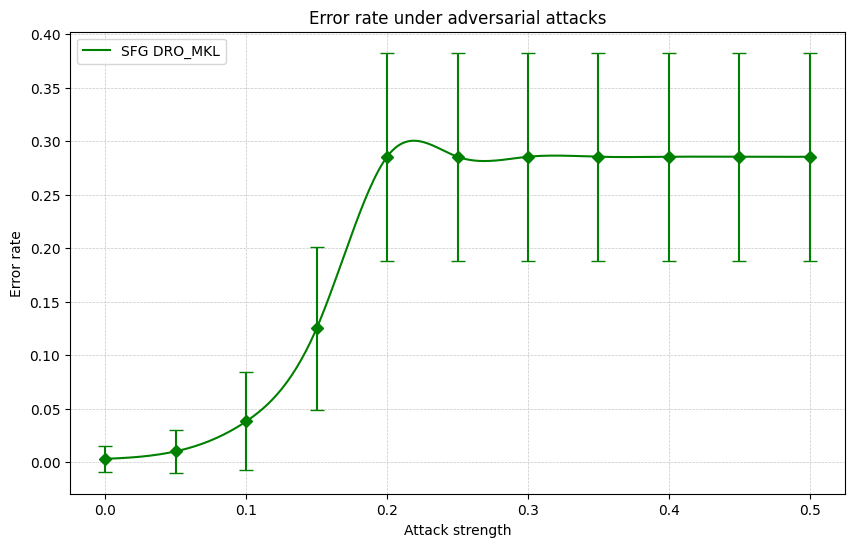

Error Rates under Adversarial Attacks:

Attack Strength		SFG DRO_MKL		
--------------------------------------------------
0.00			0.0030			
0.05			0.0100			
0.10			0.0380			
0.15			0.1250			
0.20			0.2855			
0.25			0.2855			
0.30			0.2855			
0.35			0.2855			
0.40			0.2855			
0.45			0.2855			
0.50			0.2855			


In [15]:
results = [results_sfg_MKL]

# Corresponding labels for the legend
labels = ['SFG DRO_MKL']

# Colors for the plot lines
colors = ['green', ]

# Markers for the error bar
markers = ['D', 's']  # D is for diamond shape, s is for square shape

# Title for the plot
title = 'Error rate under adversarial attacks'

# Call the function to plot error rates
plot_error_rates(results, labels, colors, markers, title)
